# Initiation
This analysis was initiated to understand the key drivers of sales for the specific product "PAPER CHAIN KIT" using the Online Retail dataset. The goal was to isolate the product's sales patterns and quantify the contributions of different factors, such as long-term trends, seasonal effects, and promotional activities. By doing so, we aim to provide actionable insights to optimize future sales strategies.

# Approach
## 1. Load and Filter Dataset
- Focus on "PAPER CHAIN KIT":
- The dataset originally contains all transaction data for various products.
- We filtered the dataset to include only rows where the Description contains "PAPER CHAIN KIT," ensuring that the analysis focuses exclusively on this product.
Aggregate Daily Sales:
- After filtering, daily sales for "PAPER CHAIN KIT" were calculated by summing up Quantity * UnitPrice for each day.

In [43]:
# Load and Preview Dataset
# To process the Online Retail Dataset with daily granularity
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

url = 'https://archive.ics.uci.edu/static/public/352/data.csv'
df = pd.read_csv(url, encoding='latin1')

# Preview dataset
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [25]:
# Filter for "PAPER CHAIN KIT" in the Description column
df = df[df['Description'].str.contains("PAPER CHAIN KIT", case=False, na=False)]

# Parse 'InvoiceDate' as datetime and set it as the time index
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.set_index('InvoiceDate', inplace=True)

# Calculate total sales
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

## 2. Feature Engineering
To better understand the factors influencing sales, we added the following features:

- Trend:
Represents the long-term growth or decline in sales over time.
Captured using a simple time index.

- Seasonality:
Represents repeating patterns based on the day of the year.
Simulated using a sinusoidal function to model potential seasonal effects.

- Promotional Events:
Simulated promotional activities (last 4 weeks) were added as binary variables (1 for promotional days, 0 otherwise).
Promotions were assumed to last 4 weeks in January (We made up this assumption as real promotion is unknown).

In [29]:
# Aggregate by Day
daily_sales = df.resample('D')['TotalSales'].sum().to_frame()

# Add a trend feature (a time index)
daily_sales['Trend'] = np.arange(len(daily_sales))

# Add seasonality (based on the day of the year)
daily_sales['DayOfYear'] = daily_sales.index.dayofyear
daily_sales['Seasonality'] = 10 * np.sin(2 * np.pi * daily_sales['DayOfYear'] / 365)

# Add promotion feature for the last 4 weeks
promotion_start_date = daily_sales.index[-28]  # Last 4 weeks (28 days)
daily_sales['Promo'] = np.where(daily_sales.index >= promotion_start_date, 1, 0)

## 3. Train Regression Model

In [34]:
# Prepare features and target variable
X = daily_sales[['Trend', 'Seasonality', 'Promo']]
y = daily_sales['TotalSales']

# Train a linear regression model
model = LinearRegression()
model.fit(X, y)

# Get feature coefficients
coefficients = pd.Series(model.coef_, index=X.columns)
print("Feature Coefficients (Driver Weights):")
print(coefficients)

# Predict sales and calculate contributions
daily_sales['PredictedSales'] = model.predict(X)
for col in X.columns:
    daily_sales[f'{col}_Contribution'] = daily_sales[col] * coefficients[col]


Feature Coefficients (Driver Weights):
Trend            -0.161449
Seasonality     -20.313638
Promo          1052.386490
dtype: float64


## 4. Visualize Results

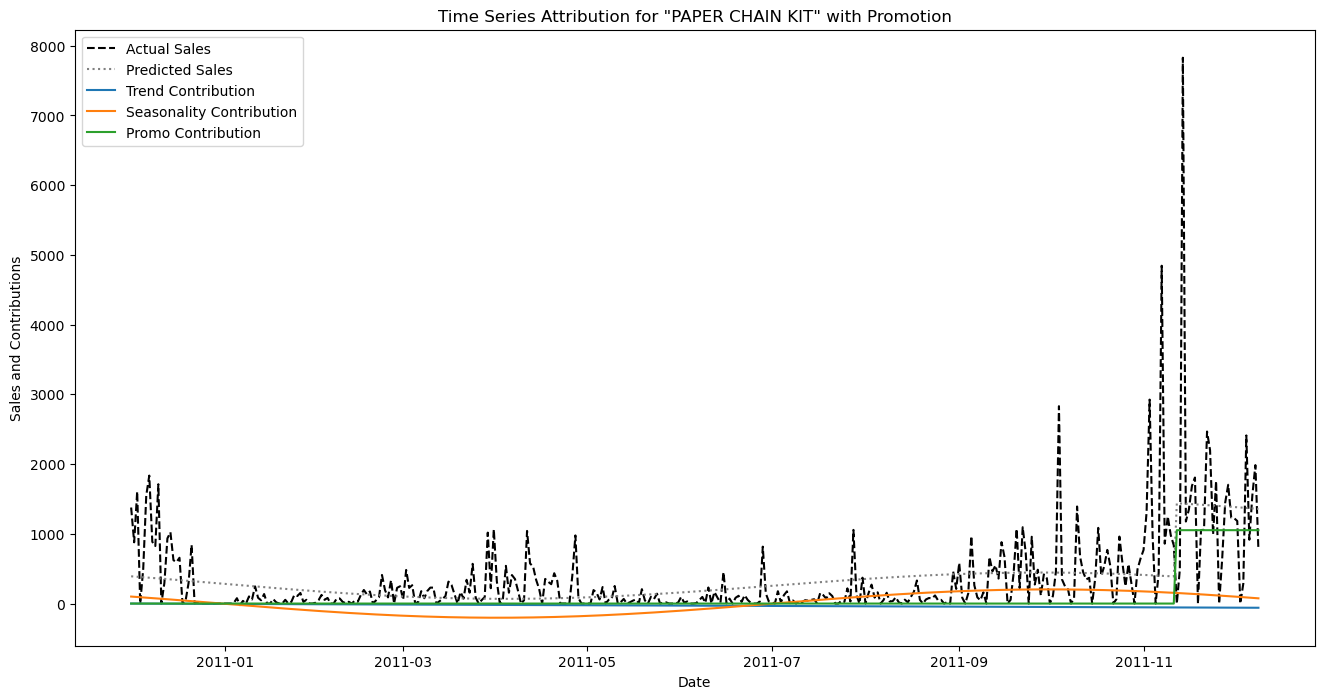

In [37]:
# Plot daily sales and contributions
plt.figure(figsize=(16, 8))

# Plot actual and predicted sales
plt.plot(daily_sales.index, daily_sales['TotalSales'], label='Actual Sales', linestyle='--', color='black')
plt.plot(daily_sales.index, daily_sales['PredictedSales'], label='Predicted Sales', linestyle=':', color='gray')

# Plot contributions
for col in ['Trend_Contribution', 'Seasonality_Contribution', 'Promo_Contribution']:
    plt.plot(daily_sales.index, daily_sales[col], label=f'{col.replace("_Contribution", "")} Contribution')

plt.legend()
plt.title('Time Series Attribution for "PAPER CHAIN KIT" with Promotion')
plt.xlabel('Date')
plt.ylabel('Sales and Contributions')
plt.show()

#### Analysis of Feature Coefficients
Based on the coefficients:

##### Trend (-0.161449):
- The trend has a negative coefficient, indicating a slight downward trajectory in daily sales over time. This suggests that, excluding seasonality and promotions, the product's baseline sales are declining.
##### Seasonality (-20.313638):
- Seasonality also has a negative coefficient, indicating that certain times of the year (or patterns in the dataset) negatively impact sales. This could mean that demand for "PAPER CHAIN KIT" decreases during specific periods, potentially outside holiday or festive seasons.
##### Promo (1052.386490):
- The very high positive coefficient for the promotional feature indicates that promotions have a significant and strong impact on daily sales.
- Promotions can lead to a substantial boost in sales, making them a critical driver for this product.

### Insights
1. Promotions are Key:
- The magnitude of the Promo coefficient shows that promotional campaigns are highly effective at increasing sales. During promotional periods, sales are boosted by over 1,000 units (on average), far outweighing the impact of trends or seasonality.
2. Declining Baseline Sales:
- The negative trend suggests that, without interventions (like promotions or addressing seasonality), the product's sales might continue to decline.
3. Seasonal Weakness:
- Negative seasonality indicates that certain times of the year may naturally see reduced sales for this product. This aligns with the idea that "PAPER CHAIN KIT" might be a festive or seasonal item, with low demand outside these periods.

Next Steps
1. Address the Declining Trend
- Investigate the reasons for the downward trend in baseline sales:
- Product Relevance: Is the product still appealing to customers? Could it be refreshed or updated?
- Competition: Are competitors offering similar products with better pricing or marketing?
- Customer Feedback: Collect and analyze customer feedback to identify potential improvements.
2. Optimize Promotions
- Leverage the strong impact of promotions to counteract declining trends and seasonal weakness:
- Timing: Schedule promotions during periods of low seasonality to stabilize sales.
- Frequency: Experiment with more frequent but shorter promotions to maintain momentum.
- Personalization: Use customer segmentation to target promotions more effectively.
3. Tackle Seasonality
- Develop strategies to reduce the impact of negative seasonality:
- Off-Season Marketing: Introduce marketing campaigns emphasizing alternative uses for the product outside its primary seasonal context.
- Bundle Offers: Pair "PAPER CHAIN KIT" with non-seasonal items to drive sales year-round.
- Diversification: Explore expanding the product line to include items that are in demand during low seasons.
4. Refine the Model
- Incorporate additional features to further explain sales drivers:
- Customer Segments: Analyze whether specific customer groups drive sales.
- Geographical Differences: Investigate regional variations in sales trends.
- Marketing Spend: Include ad spend or other marketing efforts as features.
5. Experiment with Dynamic Pricing
- Test whether adjusting pricing during non-promotional periods can improve baseline sales and reduce reliance on promotions.